In [2]:
# Per sapere che GPU è assegnata 

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15310953602159984984, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12437289963953350385
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13240625933292508450
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3508088400575831401
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [3]:
! pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp36-none-any.whl size=19867 sha256=e918fbf74a643461e1db83f99137d667cf1057fdf5c0e07cc320ea69c9f30b06
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

from keras import models, layers, optimizers, metrics, callbacks

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHVenWbiQyYyObuiEGYVhgC_aaTn789vGiMjGRWTl6ogUhurLsMDIs
Mounted at /content/drive


# Carico dati

In [5]:
data = pd.read_csv("/content/drive/My Drive/progetto_streaming/time_series_dataset.csv", sep = ";")
data["Data"] = pd.to_datetime(data["Data"])

In [6]:
data.head()

,Data,value
0,2010-01-01,41.651044
1,2010-01-02,131.286604
2,2010-01-03,117.388117
3,2010-01-04,116.461280
4,2010-01-05,123.823765


# Split train test e standardizzazione

In [7]:
train = data[data["Data"] <= pd.to_datetime("2016-12-31")]
test  = data[data["Data"]  > pd.to_datetime("2016-12-31")]

I dati vengono standardizzati calcolando la "maschera" sul train set.

In [ ]:
mean = train["value"].mean()
std = train["value"].std()

train["value"] = (train["value"] - mean)/std
test["value"] = (test["value"] - mean)/std

stand_data = pd.concat([train, test])

Viene creato il dataset per le previsioni con reti neurali che consiste in sequenze di train (2 anni di dati) e test (334 giorni di dati).


In [9]:
def create_dataset(X, y, time_steps=1, prev_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - prev_steps + 1):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        V = y.iloc[i + time_steps : i + time_steps + prev_steps].values
        ys.append(V)
    return np.array(Xs), np.array(ys)

In [10]:
time_step = 730
prev_step = 334

X, y = create_dataset(stand_data["value"], stand_data["value"], time_step, prev_step)

In [11]:
# calcolo ultimo indice train per splittare i dati in train e test

last_index = stand_data.loc[len(train)-1:len(train)-1]["value"].values[0]

for i in range(len(X)):
    if last_index == X[i][-1]:
        print(i)
        break
last_index = i

1827


In [12]:
# Split e reshape per rete neurale

X_train, X_test = X[:last_index], X[last_index:]
y_train, y_test = y[:last_index], y[last_index:]


X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

y_train = y_train.reshape(-1, y_train.shape[1])
y_test = y_test.reshape(-1, y_test.shape[1])

In [13]:
X_train.shape, X_test.shape

((1827, 730, 1), (397, 730, 1))

# Modelli di prova

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

Si provano due semplici modelli il primo con un layer LSTM e e il relativo strato di output, il secondo con un layer GRU e lo starto di output.

L'ottimizzatore utilizzato è ADAM.

## LSTM

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [ ]:
model = models.Sequential()

model.add(layers.LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), 
                      return_sequences = False))

model.add(layers.Dense(prev_step, activation = "linear"))

In [ ]:
model.compile(loss="mse",
            optimizer= optimizers.Adam(), 
            metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=100,
                    validation_split=0.2,
                    callbacks = [es])

In [ ]:
x_plot = list(range(1,history.epoch[-1]+2))
   

plot_history(history)

In [ ]:
test_mse, test_mae = model.evaluate(X_test, y_test)
print("TEST MSE:", test_mse)
print("TEST MAE:", test_mae)

In [ ]:
# Previsioni sul test e trasformazione inversa alla standardizzazione

pred = model.predict(X_test)
true_pred = pred*std + mean
true_y_test = y_test*std + mean

print("MAPE on test set: " + str(mape(true_y_test, true_pred)))
print("MSE on test set: " + str(mean_squared_error(true_y_test, true_pred)))

## GRU

In [ ]:
model = models.Sequential()

model.add(layers.GRU(128, input_shape = (X_train.shape[1], X_train.shape[2]), 
                      return_sequences = False))


model.add(layers.Dense(prev_step, activation = "linear"))

In [ ]:
model.compile(loss="mse",
            optimizer= optimizers.Adam(), 
            metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=100,
                    validation_split=0.2,
                    callbacks = [es])

In [ ]:
x_plot = list(range(1,history.epoch[-1]+2))
   

plot_history(history)

In [ ]:
test_mse, test_mae = model.evaluate(X_test, y_test)
print("TEST MSE:", test_mse)
print("TEST MAE:", test_mae)

In [ ]:
# Previsioni sul test e trasformazione inversa alla standardizzazione

pred = model.predict(X_test)
true_pred = pred*std + mean
true_y_test = y_test*std + mean

print("MAPE on test set: " + str(mape(true_y_test, true_pred)))
print("MSE on test set: " + str(mean_squared_error(true_y_test, true_pred)))

# AUTOML

Si propone ora una tecnica di ottimizzazione di iperparametri per migliorare i risultati ottenuti. 
Si utilizza un architettura di soli layers LSTM e Dense dove sia il *numero di strati* che di *neuroni* sono considerati iperparametri da ottimizzare.

Inoltre viene ottimizzato anche il *learning rate*  e il *batch size*.

La metrica da minimizzare è il *MSE*, usando la libreria pyGPGO che permette solo massimizzazioni di funzioni black box, la funzione che si utilizzerà come valutazione del modello restituirà l'inverso del *MSE* che alla fine verà nuovamente convertito nella forma corretta.

La funzione di acquisizione utilizzata è *Expected improvement*.

In [14]:
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [15]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

In [16]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [17]:
def resultDataframe(hyperparams, score, initial):
  result = pd.DataFrame(hyperparams,columns=['lr', 'n_neuron', 'n_neuron1', 'n_layers_LSTM', 'n_layers_dense', 'n_batch_size'])
  result['mse'] = 1/score
  result['phase']="increment"
  result.loc[0:initial-1,'phase']='initial'
  return result

In [18]:
def create_model(n_neuron, n_neuron1, n_layers_LSTM, n_layers_dense): 
     
    model = models.Sequential()

    if int(n_layers_LSTM) == 0:
        condition = False
    else: 
        condition = True

    model.add(layers.LSTM(int(n_neuron), input_shape = (X_train.shape[1], X_train.shape[2]), 
                      return_sequences = condition))
    for i in range(int(n_layers_LSTM)):
        if i == int(n_layers_LSTM) -1:
            condition = False
        model.add(layers.LSTM(int(n_neuron), return_sequences = condition))

    for i in range(int(n_layers_dense)):
            model.add(layers.Dense(int(n_neuron1), activation="relu"))
    
    model.add(layers.Dense(prev_step, activation="linear"))

    return model

In [ ]:
range_lr = [0.0001, 0.01]
range_neuron = [64, 1024]
range_neuron1 = [16, 1024]
range_layers_LSTM = [0, 3]
range_layers_dense = [0,3]
range_batch_size = [1, 128]


param = {'lr': ('cont', range_lr), 
         'n_neuron': ('int', range_neuron),
         'n_neuron1' : ('int', range_neuron1),
         'n_layers_LSTM' : ('int', range_layers_LSTM),
         'n_layers_dense' : ('int', range_layers_dense),
         'n_batch_size' : ('int', range_batch_size)         
         }

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")

In [ ]:
# Funzione da massimizzare
def compute_mse(lr, n_neuron, n_neuron1, n_layers_LSTM, n_layers_dense, n_batch_size):

    model = create_model(n_neuron, n_neuron1, n_layers_LSTM, n_layers_dense)

    model.compile(optimizer=optimizers.Adam(learning_rate = lr),
                  loss="mse",
                  metrics=["mae"])
    
    
    
    model.fit(X_train, y_train, 
              batch_size = int(n_batch_size),
              epochs = 100,
              validation_split = 0.2,
              callbacks = [es],
              verbose = 0)
    
    score = 1 / model.evaluate(X_test, y_test)[0]

    return score

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


SMBO_exp_nn = GPGO(rf_model, f_acq,
                   compute_mse,
                   param, n_jobs = 1)
SMBO_exp_nn.run(init_evals=10,
                max_iter=70)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
13/13 [==============================] - 1s 53ms/step - loss: 0.6908 - mae: 0.6282
init   	 [3.80794718e-03 9.24000000e+02 2.86000000e+02 2.00000000e+00
 0.00000000e+00 2.10000000e+01]. 	  1.388249505033405 	 1.523981853431295
init   	 [1.64458454e-03 5.30000000e+02 2.30000000e+02 2.00000000e+00
 2.00000000e+00 8.80000000e+01]. 	  1.523981853431295 	 1.523981853431295
init   	 [3.40371525e-03 9.35000000e+02 6.79000000e+02 2.00000000e+00
 1.00000000e+00 5.30000000e+01]. 	  1.417931459274147 	 1.523981853431295
init   	 [9.70210754e-03 5.55000000e+02 4.29000000e+02 1.00000000e+00
 1.00000000e+00 6.40000000e+01]. 	  1.441451918699275 	 1.523981853431295
init   	 [9.92289444e-03 2.24000000e+02 4.75000000e+02 1.00000000e+00
 1.00000000e+00 1.25000000e+02]. 	  1.3218057160487144 	 1.523981853431295
init   	 [4.37625568e-03 6.24000000e+02 4.90000000e+02 2.00000000e+00
 2.00000000e+00 4.20000000e+01]. 	  1.4982303124605398 	 1.523981853

In [ ]:
result = resultDataframe(SMBO_exp_nn.GP.X, SMBO_exp_nn.GP.y, initial=2)

In [ ]:
result

,lr,n_neuron,n_neuron1,n_layers_LSTM,n_layers_dense,n_batch_size,mse,phase
0,0.003808,924.0,286.0,2.0,0.0,21.0,0.720332,initial
1,0.001645,530.0,230.0,2.0,2.0,88.0,0.656176,initial
2,0.003404,935.0,679.0,2.0,1.0,53.0,0.705253,increment
3,0.009702,555.0,429.0,1.0,1.0,64.0,0.693745,increment
4,0.009923,224.0,475.0,1.0,1.0,125.0,0.756541,increment
...,...,...,...,...,...,...,...,...
75,0.003491,467.0,767.0,1.0,2.0,79.0,0.652420,increment
76,0.005081,451.0,827.0,1.0,2.0,15.0,0.678401,increment
77,0.008959,174.0,242.0,2.0,2.0,7.0,1.077608,increment
78,0.002219,608.0,740.0,0.0,2.0,54.0,0.739846,increment


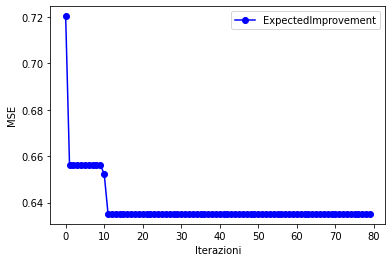

In [ ]:
ndcg_exp_nn = np.minimum.accumulate(result["mse"])


#plt.figure(figsize=(10,8))
plt.plot(ndcg_exp_nn,marker='o',color='blue',label="ExpectedImprovement")
plt.ylabel("MSE")
plt.xlabel("Iterazioni")
plt.legend()
plt.show()

In [ ]:
print("MSE modello migliore test: " + str(1/SMBO_exp_nn.getResult()[1]))

MSE modello migliore test: 0.6350775957107544


In [ ]:
# Parametri modello migliore

SMBO_exp_nn.getResult()[0]

OrderedDict([('lr', 0.0013759092469154276),
             ('n_neuron', 246.0),
             ('n_neuron1', 863.0),
             ('n_layers_LSTM', 2.0),
             ('n_layers_dense', 2.0),
             ('n_batch_size', 118.0)])

In [158]:
X = X.reshape(-1,730,1)

In [ ]:
#np.random.seed(42)
#tf.random.set_seed(42)

best_mod = create_model(246, 863, 2, 2)

best_mod.compile(loss="mse",
            optimizer= optimizers.Adam(lr = 0.0013759092469154276), 
            metrics=['mae'])

history = best_mod.fit(X_train, y_train,
                    batch_size=118,
                    epochs=100,
                    validation_data = (X_test, y_test),
                    callbacks = [es])

In [ ]:
x_plot = list(range(1,history.epoch[-1]+2))
 

plot_history(history)

In [49]:
test_mse, test_mae = best_mod.evaluate(X_test, y_test)
print("TEST MSE:", test_mse)
print("TEST MAE:", test_mae)

13/13 [==============================] - 1s 63ms/step - loss: 0.7029 - mae: 0.6146
TEST MSE: 0.7028965950012207
TEST MAE: 0.6146093606948853


In [22]:
# Previsioni e trasformzione inversa alla standardizzazione

pred_train = best_mod.predict(X_train)*std + mean
pred_test = best_mod.predict(X_test)*std + mean


print("MAPE on train set: " + str(mape(y_train*std + mean, pred_train)))
print("MAPE on test set: "+ str(mape(y_test*std + mean, pred_test)))


print("MSE on train set: "+ str(mean_squared_error(y_train*std + mean, pred_train)))
print("MSE on test set: " + str(mean_squared_error(y_test*std + mean, pred_test)))

MAPE on train set: 20.418118234420145
MAPE on test set: 18.32667782698704
MSE on train set: 572.5470019276233
MSE on test set: 815.4316568336255


# Previsioni e grafici finali

Per le previsioni finali della rete neurale si allena il modello migliore ottenuto per altre 25 epoche sul test set, in quanto precedentemente non era stato usato e anche per conferirgli più importanza essendo i dati più recenti disponibili.

In [284]:
X_final = data[data["Data"] >= pd.to_datetime("2017-01-01")]
X_final = (X_final["value"] - mean)/std
X_final = X_final.values.reshape(1,-1,1)

In [ ]:
best_mod.fit(X_test, y_test, 
             epochs = 25)

In [ ]:
pred_ML = best_mod.predict(X_final)[0] * std + mean

In [6]:
prova = pd.read_csv('/content/drive/My Drive/progetto_streaming/SDMTSA_790032_0.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [287]:
prova["ML"] = pred_ML

In [ ]:
prova.plot(figsize=(10,7))
plt.ylabel("Value")

In [262]:
final = pd.read_csv("/content/drive/My Drive/progetto_streaming/SDMTSA_790032_0.csv")

In [263]:
final["ML"] = pred_ML

In [265]:
final.to_csv("/content/drive/My Drive/progetto_streaming/SDMTSA_790032_0.csv", index=False)